## Exercise: Build a logistic regression model to predict fish species

Using the fish dataset in this repo (location relative to this notebook: `../datasets/fish/Fish.csv`) do the following:

1. Split the data into labels and features, with the "species" column being the label and the other columns as features.
2. Split the fish data into training and validation sets.
3. Fit the model!
4. Score the model, what is this value? How should you interpret it?
5. Examine the coefficents and intercept value...
    * These are a strange shape compared to linear regression. 
    * Can you explain what they are?
6. Compute and plot the a "confusion matrix"
    * First of all you might want to answer the question: what IS a confusion matrix?
    * Hint 1: [https://machinelearningmastery.com/confusion-matrix-machine-learning/](https://machinelearningmastery.com/confusion-matrix-machine-learning/)
    * Hint 2: [https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
    * Hint 3: [https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix](https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix)
    * Is your model good at some classes and bad at others?
    * Are there any interesting trends in the confusion matrix?

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load the data
fish_dataset = pd.read_csv('../datasets/fish/Fish.csv')
fish_dataset.head(5)

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [4]:
# 1. split the data into labels and features
labels = fish_dataset['Species']
features = fish_dataset.drop(columns=['Species'])

# 2. test/train split
training_data, test_data, training_labels, test_labels = train_test_split(features, labels, test_size=0.2)

In [7]:
# 3. fit the model
model = LogisticRegression()
model.fit(training_data, training_labels)

# 4. score the model
print(model.score(test_data, test_labels))

0.625


/Users/tylerbettilyon/opt/anaconda3/envs/sb-data-science/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### oh... we don't love that error...

It's telling us that during the training process the model had not converged to a stable state. During training the coefs are each adjusted by a small amount (the exact amount depends on the solver used, and how bad the predictions were during this round of training). Eventually, as the model trains we expect the adjustements to get smaller and smaller as the model "converges" to a state where it's predictions are no longer improving due to the new adjustments. 

Lets give our model some more rounds to converge.

In [16]:
# 3. fit the model
model = LogisticRegression(max_iter=10000)
model.fit(training_data, training_labels)

# 4. score the model
print(model.score(test_data, test_labels))


0.90625


## Note that

A ovr regression will generally converge much faster... lets see if that holds up in this case:

In [23]:
# 3. fit the model
model = LogisticRegression(max_iter=500, multi_class='ovr')
model.fit(training_data, training_labels)

# 4. score the model
print(model.score(test_data, test_labels))

0.90625


**Faster to train, and identical accuracy in this case** That won't ALWAYS be true, sometimes `multinomial` will outperform `ovr` but it's worth trying ovr first because if it's good enough you might not need to spend the extra time training a `multinomial`.

### What was that score value?

It's "accuracy" meaning our model is right about the species of fish 90% of the time. Not bad!

In [24]:
print(model.coef_, '\n\n', model.intercept_)

[[-1.21907943e-02 -4.16609370e-01 -2.63220839e-01  8.22562081e-01
   1.59503834e+00 -1.26440838e-01]
 [-2.62137229e-02 -2.06440487e-02 -1.32556533e-01 -5.01133791e-01
   2.07879014e+00 -8.82756640e-02]
 [-3.01476313e-03  3.97826115e-01  2.44731002e+00 -2.88113121e+00
   1.48207830e-01  1.90982021e+00]
 [-2.55466783e-02  4.25541386e-01  4.59213909e-01  5.25986062e-01
  -5.39465677e-01 -1.74508185e-01]
 [-2.11633310e-02  5.85844361e-02 -1.51025876e+00  1.44227535e+00
  -3.49544138e-01  2.01983779e+00]
 [-8.19201345e-02  4.25444227e-01 -5.46126973e-03  8.22216490e-02
  -1.53145262e+00 -7.39968655e-01]
 [ 1.67949335e-03 -4.75024959e-01 -4.85715260e-02  3.63223671e-01
  -2.74465267e-01  1.03913983e+00]] 

 [-21.13194703   0.19167867  -0.43199772 -34.08286519  -5.61106896
   1.65634396  -3.76674339]


## What is that?

The `coef_` is 7 arrays each of length 6. That is, one array of coefficents for each of the sigmoid functions that we fit, and one `coef` per input feature in each of those 5 arrays. 

7 comes from the number of unique fish species in our dataset. 
6 comes from the number of columns in the training data.

The intercept also has 7 values: one for each of the species == one for each of the fitted sigmoid functions.

## Part 6, the confusion matrix

A confusion matrix is a helpful visual tool to identify how our model is performing with respect to each individual class. It is a `len(labels) x len(labels)` matrix. The columns indicate our model's prediction and the rows indicate the actual labels.

The true lables are given by row, the predicted labels are given by column.

[[ 5  0  0  0  0  0  0]
 [ 2  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0  2  0  0  0]
 [ 0  0  0  0  4  0  0]
 [ 0  0  0  0  0  2  0]
 [ 0  0  1  0  0  0  0]]


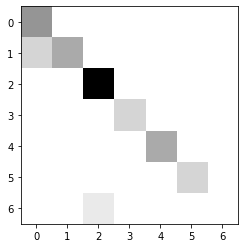

In [26]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_data)
cm = confusion_matrix(test_labels, predictions)
print(cm)
plt.imshow(cm, cmap='binary')

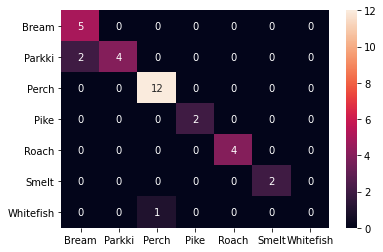

In [32]:
# We can make a prettier one using an extension to matplotlib called seaborn
# Note, you may have to install this library in Anaconda (or your preferred package manager)
import seaborn as sn

name_labels = model.classes_

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

## Notes

* This visualization makes it clear that our test data is very small. 
* We're usually right, but we've got 2 forms of error
    * 2 Parkki's being classified as Breams
    * 1 Whitefish being classified as a Perch
    
Just for fun, lets see this chart with the training data.

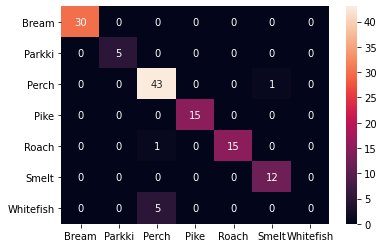

In [33]:
predictions = model.predict(training_data)
cm = confusion_matrix(training_labels, predictions)
sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

**This dataset is still way to small honestly, but Whitefish are apparently a challenge, possibly because we have so few samples of that class compared to the others**

This problem, called "class imbalance" is something to be aware of. ML Models work best when each class is more-or-less equally represented in the training data. But do note, that wasn't a problem for Parkki in this case...